# Formalia:

Please read the [assignment overview page](https://github.com/lalessan/comsocsci2022/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday, April 5th at 23:55. Hand in your Jupyter notebook file (with extension `.ipynb`) via DTU Learn _(Course Content, Assignemnts, Assignment 2)_


Remember to include in the first cell of your notebook:
* the link to your group's Git repository
* group members' contributions

## Part 1: TF-IDF

For this exercise, you need the following data: 
* The r/wallstreetbets submissions (either the one provided by me [here](https://github.com/lalessan/comsocsci2021/blob/master/data/wallstreet_subs.csv.gz) or the one you downloaded in Week 6).
* The list of 15 stocks you identified in Week 6, Exercise 2.



In [40]:
import pandas as pd
import requests
import io
import re
import nltk
from nltk.corpus import stopwords
import string
import itertools
import os
from tqdm import tqdm
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import datetime
import numpy as np
from collections import Counter
import shifterator as sh
import networkx as nx
import netwulf as nw
from netwulf import visualize
from networkx import Graph
import random
from community import community_louvain
seed = 42
np.random.seed(seed)
random.seed(seed)

In [1]:
# Downloading the r/wallstreetbets submissions from the GitHub account
url = "https://raw.githubusercontent.com/JaQtae/SocInfo2022/main/wallstreet_subs1.csv"
download = requests.get(url).content

df = pd.read_csv(io.StringIO(download.decode('utf-8')))

We create a new column containing both the title and the textual content of each submission - the so called __text__.

In [2]:
df["text"] = df["title"] + " " + df["selftext"]

We recreate the list of 15 stocks identified in week 6. <br>
We start by finding all ticker symbols contained in the text of each submission..

In [3]:
def find_tickers(text):
    tickers = re.findall(r"[$][a-zA-Z]+", text)
    tickers_uppercase = [t.upper()[1:] for t in tickers] # indexing to remove '$'
    tickers = " ".join(tickers_uppercase)
    return tickers
                         
df["tickers"] = df.apply(lambda x: find_tickers(x["text"]), axis=1)

Then we create the list of the 15 most frequently occuring ticker symbols using a frequency distribution from the NLTK library. 

In [6]:
# Concatenate all tickers to a string.
all_tickers = df["tickers"].str.cat(sep=' ')
# Tokenize to use freqdist
tokens = nltk.word_tokenize(all_tickers)

fd = nltk.FreqDist(sorted(tokens, reverse=True))
top_15 = fd.most_common(15) 

The list:

In [7]:
top_15_tickers = [ticker[0] for ticker in top_15]
top_15_tickers

['SPY',
 'TSLA',
 'SPCE',
 'PLTR',
 'MSFT',
 'ROPE',
 'AAPL',
 'AMZN',
 'NIO',
 'ZM',
 'AMD',
 'BABA',
 'GME',
 'DIS',
 'BA']


#### 1.1 Tokenize the __text__ of each submission. Create a column __tokens__ in your dataframe containing the tokens. Remember to follow the instructions in Week 6, Exercise 3.  


We solve this by defining the clean_tokens function below.

In [5]:

# Define stop words to also include punctuation
stop = set(stopwords.words('english') + list(string.punctuation))

# Function to tokenize and clean the text of each submission
def clean_tokens(text):
    tokens = nltk.word_tokenize(text)
    # In the list comprehension below, we exclude URL's, stopwords and numbers as well as setting all characters to lowercase
    clean_tokens = [re.sub(r'http', '', i).lower() for i in tokens if str(i).isalpha()]
    clean_tokens = [t for t in clean_tokens if t not in stop]
    return clean_tokens

In [74]:
df["tokens"] = df.apply(lambda x: clean_tokens(x["text"]), axis=1)

We now have the tokens column: 

In [75]:
for i in range(len(df["tokens"])):
    if "the" in df["tokens"][i]:
        print(df["tokens"][i])

#### 1.2 Find submissions discussing at least one of the top 15 stocks you identified above (follow the instructions in Week 6, Exercise 3).


In [76]:
# Make a column containing a list of the stock tickers
df["tickers_list"] = df.apply(lambda x: x["tickers"].split(), axis=1)

In [77]:
# This functions finds the intersection between the listed tickers and the top 15 tickers
def find_top_tickers(list_of_tokens):
    return [t for t in list_of_tokens if t in top_15_tickers]

In [78]:
# We create a new column "stock" containing the output of the find_top_tickers function applied to the "tickers_list" column
# Note that the "tickers_list" column already contains the ticker symbols included in the text of the submission. 
df["stock"] = df.apply(lambda x: find_top_tickers(x["tickers_list"]), axis=1)

In [79]:
# Here we handle cases where one post discusses more than one stock by applying the explode function to the "stock" column. 
df = df.explode("stock")
df["stock"] = df["stock"].fillna('Other')

In [80]:
# Reindex df to remove duplicate indices. 
df = df.reset_index()

In [81]:
top_stock_subs_idx = df.index[df['stock'] != "Other"].tolist()

We can now investigate some submissions discussing at least one of the 15 most popular stocks

In [82]:
print(*("SUBMISSION DISCUSSING '" + df["stock"][sub] + "':\n" + df["text"][sub] + "\n" for sub in top_stock_subs_idx[:2]), sep = "\n")

SUBMISSION DISCUSSING 'ROPE':
Don’t sell your OTM puts tomorrow morning I hope this doesn’t age well but tomorrow’s gonna be a blood bath for bear gang.  Between the Delta, Vega, and Theta driven declines you’re probably going to be thinking about $ROPE all day.  

Much like dead cat bounces, Tuesday through Thursday should show us at least one day of market correction closer to reality.  Don’t get me wrong, IV crush is going to keep you in the deep red on your puts without a doubt but at least you’ll recover something to use to rollforward to May - July options.

SUBMISSION DISCUSSING 'SPY':
If exponential patterns hold, we're looking at 100K deaths by 4/15. I modeled deaths as exponentially growing 8 days ago - there was going to be 100K deaths by 4/15.

I ran the numbers again tonight, and 4/15 to the day is still when the magical 100K barrier is projected to occur.

If you think market sentiment is at all driven by irrational milestones like that, it'll probably mark some market in

#### 1.3 Now, we want to find out which words are important for each *stock*, so we're going to create several ***large documents, one for each stock***. Each document includes all the tokens related to the same stock. We will also have a document including discussions that do not relate to the top 15 stocks.


In [83]:
# Create an empty dictionary to contain a corpus of the tokens relating to each of the tickers
stock_corpus = {}        
for topic in df["stock"].unique(): # index to exlude "other"
       stock_corpus[topic] = []

In [84]:


# First append all list of tokens to the associated ticker in the dictionary. 
# Each of the dict values will be list of lists
for i in range(len(df)):
    #print(i)
    stock_corpus[df["stock"][i]].append(df["tokens"][i])

# Collapse the lists of lists
for key in stock_corpus.keys():
    stock_corpus[key] = list(itertools.chain.from_iterable(stock_corpus[key]))

#### 1.4 Now, we're ready to calculate the TF for each word. Find the top 5 terms within __5 stocks of your choice__. 



In [85]:
def term_freq(doc, n):
    fd = nltk.FreqDist(doc).most_common(n)
    tf_list = [fd[i][1]/len(doc) for i in range(n)]
    return [(fd[i][0], round(tf_list[i]*100,2)) for i in range(n)] 

In [89]:
# We investigate the term frequencies of the top 5 terms of the following 5 stocks
print("GameStop / GME:          {}".format(term_freq(stock_corpus['GME'], 5)))
print("Virgin Galactic / SPCE:  {}".format(term_freq(stock_corpus['SPCE'], 5))) 
print("Microsoft / MSFT:        {}".format(term_freq(stock_corpus['MSFT'], 5)))
print("Apple / AAPL:            {}".format(term_freq(stock_corpus['AAPL'], 5)))
print("AMD:                     {}".format(term_freq(stock_corpus['AMD'], 5))) 

GameStop / GME:          [('long', 29.08), ('gme', 28.88), ('gamestop', 1.1), ('fake', 1.09), ('bullish', 1.06)]
Virgin Galactic / SPCE:  [('spce', 2.84), ('market', 0.92), ('money', 0.87), ('company', 0.85), ('space', 0.63)]
Microsoft / MSFT:        [('price', 3.49), ('option', 2.41), ('msft', 1.95), ('strike', 1.8), ('stock', 1.71)]
Apple / AAPL:            [('earnings', 1.49), ('amp', 1.47), ('gt', 1.44), ('aapl', 1.19), ('apple', 0.78)]
AMD:                     [('amd', 8.82), ('intc', 3.55), ('cpus', 1.76), ('chips', 1.28), ('keep', 1.27)]


##### 1.4.1  Describe similarities and differences between the stocks.



__Answer:__
* There is a general trend for the stock ticker symbol itself to be one of the top terms used in submissions relating to that stock. 
* There is, however, a difference in the ordering of the terms with the highest frequencies; for SPCE and AMD the ticker symbol has the highest term frequency, whereas MSFT and AAPL are dominated by other terms - "price" and "earnings" respectively. 
* The most frequent terms generally reflect the field of business for the related companies; e.g. "space" is mentioned for SPCE (a space tourism company), "cpus" and "chips" for AMD (a chip-building company). 
* Some unexpected and apparently uninformative terms like "amp" and "gt" appears as the top terms for all of the selected stocks. We investigated this a bit further: 




In [123]:
# Below are some submission tokens including the mysterious "amp" term. 
print(df["tokens"][df["tokens"].apply(lambda x: any([y in x for y in ["amp"]]))][:10])

7     [daily, discussion, thread, april, daily, trad...
9     [spy, sure, might, wrong, fuck, actually, miss...
32    [spx, likely, go, higher, fooled, amp, img, he...
33    [spx, likely, go, higher, fooled, amp, img, he...
34    [spx, likely, go, higher, fooled, amp, img, he...
35    [spx, likely, go, higher, fooled, amp, img, he...
48    [puts, printing, amp, amp, amp, amp, trying, l...
51    [bears, rejoice, still, bulls, buying, means, ...
52    [medtronic, confirms, spacex, making, vital, p...
53    [covid, bankruptcy, hey, wanted, put, feelers,...
Name: tokens, dtype: object


Let's look closer at some of these..

In [124]:
print(df["text"][7])

Daily Discussion Thread - April 06, 2020 Your daily trading discussion thread. Please keep the shitposting to a minimum. 

Looking for a trade? Check out these zesty [DD Threads](https://reddit.com/r/wallstreetbets/search?sort=new&amp;restrict_sr=on&amp;q=flair%3ADD)

[Weekly Earnings Discussion Thread](https://www.reddit.com/r/wallstreetbets/search?sort=new&amp;restrict_sr=on&amp;q=flair%3A%22Earnings%20Thread%22)

[WSB Discord Chat](https://discordapp.com/invite/xpdbeGT)


In [125]:
print(df["text"][9])

SPY PREDICTION- I'M 100% SURE THAT I MIGHT BE WRONG How in the fuck did we actually miss the bottom. I understand Warren Buffet's stance on selling some of his airline stocks with Delta and Southwest, but along with the COO of Apple selling around 9M worth of his shares in Apple... My peanut brain can't handle the conflicting views of spy going green. As I post this, futures are up almost 4%. Wow, amazing. So great for the Bulls. Bigly gains.

&amp;#x200B;

BUT HOLD THE FUCK ON.

&amp;#x200B;

A BULL TRAP IS A "BULL TRAP" ITS LITERALLY MADE TO MAKE YOU GIVE UP ALL HOPE. ITS DIRECT PURPOSE IS TO CREATE AN EXTREMELY BELIEVABLE MIRAGE. ONCE YOU'VE DECIDED YOU FINALLY HIT BOTTOM, THAT'S WHEN THEY PULL THE FUCKING CARPET AND AWAAAAAAAAAAY YOU GO, TUMBLING TO THE DEPTHS OF SPY.

or I just got a little carried away in paint and wanted to create my own SPY prediction.

&amp;#x200B;

Good luck retards, we all need it.

TLDR: SPY $240 4/17


It looks like the "amp" terms is used in "&amp" in some URL's and some markdown text such as "&amp#x200B;" which is used to create some whitespace in the submissions according to https://www.reddit.com/r/OutOfTheLoop/comments/9abjhm/what_does_x200b_mean/

This would explain the frequency of the term, even though it does not tell a lot about the stocks and would ideally have been filtered in the tokenization and cleansing process. 

##### 1.4.2  Why aren't the TFs not necessarily a good description of the stocks? <br>

__Answer:__ <br>
Terms with a high frequency doesn't necessarily tell anything specific about the individual stocks, as such terms might be present in multiple contexts, such as submissions relating to entirely different stocks, like we have seen above with "amp". 

##### 1.4.3  Next, we calculate IDF for every word.  <br>

In [162]:
chosen_stocks = ["GME", "SPCE", "MSFT", "AAPL", "AMD"]

N = 5
temp = []
for ticker in tqdm(chosen_stocks):
    temp.append(stock_corpus[ticker])

# Here we have all unique terms from the documents relating to the chosen_stocks. 
unique_terms = list(set([item for sublist in temp for item in sublist]))


100%|██████████| 5/5 [00:00<?, ?it/s]


In [170]:
# Calculating the inverse document frequency. 
IDF = defaultdict(int)
for term in tqdm(unique_terms):
    doc_count = 0
    for doc in chosen_stocks:   
        if term in stock_corpus[doc]:
            doc_count += 1
    IDF[term] = np.log(N/(doc_count + 1))

100%|██████████| 11015/11015 [07:30<00:00, 24.45it/s]


In [173]:
#Saving IDF results
with open('IDF.txt', 'w') as convert_file:
     convert_file.write(json.dumps(IDF))


#### 1.4.4 What base logarithm did you use? Is that important?
 __Answer:__
 Here we used the natural logarithm. The choice of logarithmic base is important as this influences how much importance is  assigned to terms occuring only in few documents. 

#### 1.4.5 We're ready to calculate TF-IDF. Do that for the __5 stock of your choice__. 
>   * List the 10 top TF words for each stock.
>   * List the 10 top TF-IDF words for each stock.

In [190]:
# Redefining the TF-function to only return words
def term_freq_words_only(doc, n):
    fd = nltk.FreqDist(doc).most_common(n)
    tf_list = [fd[i][1]/len(doc) for i in range(n)]
    return [fd[i][0] for i in range(n)] 

# Another version to calculate the TF's of all terms in a document and not just the most common ones. 
def term_freq_whole_doc(doc):
    fd = nltk.FreqDist(doc)
    return {k : fd[k]/len(doc) for k in fd.keys()}

In [194]:
print("Top 10 TF words for selected stocks:\n")
for ticker in chosen_stocks:
    print("{0: <5}: {1}".format(ticker, term_freq_words_only(stock_corpus[ticker], 10)))

print("\nTop 10 TF-IDF words for selected stocks:\n")
for ticker in chosen_stocks:
    TFs = term_freq_whole_doc(stock_corpus[ticker])
    TFIDFs = {word: TFs[word]*IDF[word] for word in set(stock_corpus[ticker])}
    top_10 = sorted(TFIDFs, key=TFIDFs.get, reverse=False)[:10]
    print("{0: <5}: {1}".format(ticker, top_10))

Top 10 TF words for selected stocks:

GME  : ['long', 'gme', 'gamestop', 'fake', 'bullish', 'test', 'bunch', 'positive', 'terrible', 'keywords']
SPCE : ['spce', 'market', 'money', 'company', 'space', 'short', 'even', 'going', 'fucking', 'amp']
MSFT : ['price', 'option', 'msft', 'strike', 'stock', 'options', 'value', 'amp', 'money', 'sell']
AAPL : ['earnings', 'amp', 'gt', 'aapl', 'apple', 'market', 'stock', 'click', 'week', 'share']
AMD  : ['amd', 'intc', 'cpus', 'chips', 'keep', 'graphic', 'new', 'gpu', 'mind', 'laptop']

Top 10 TF-IDF words for selected stocks:

GME  : ['long', 'gme', 'fake', 'bullish', 'test', 'bunch', 'positive', 'terrible', 'stock', 'would']
SPCE : ['market', 'money', 'company', 'space', 'short', 'even', 'going', 'fucking', 'amp', 'get']
MSFT : ['price', 'option', 'msft', 'strike', 'stock', 'options', 'value', 'amp', 'money', 'sell']
AAPL : ['earnings', 'amp', 'gt', 'aapl', 'apple', 'market', 'stock', 'click', 'week', 'share']
AMD  : ['amd', 'intc', 'keep', 'new',


>   * Are these 10 words more descriptive of the stock? If yes, what is it about IDF that makes the words more informative?



__Answer:__ <br>
There is actually little difference between the top words found by the two methods. The words found with TF-IDF is this not significantly different from the words found using solely TF. 

#### 1.4.6 Visualize the results in a Wordcloud and comment your results (follow the instrutions in Week 6, Exercise 4). 


In [222]:
wordcloud = []
for ticker in tqdm(chosen_stocks):
    wordcloud.append(WordCloud(collocations = False).generate(" ".join(stock_corpus[ticker])))

100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


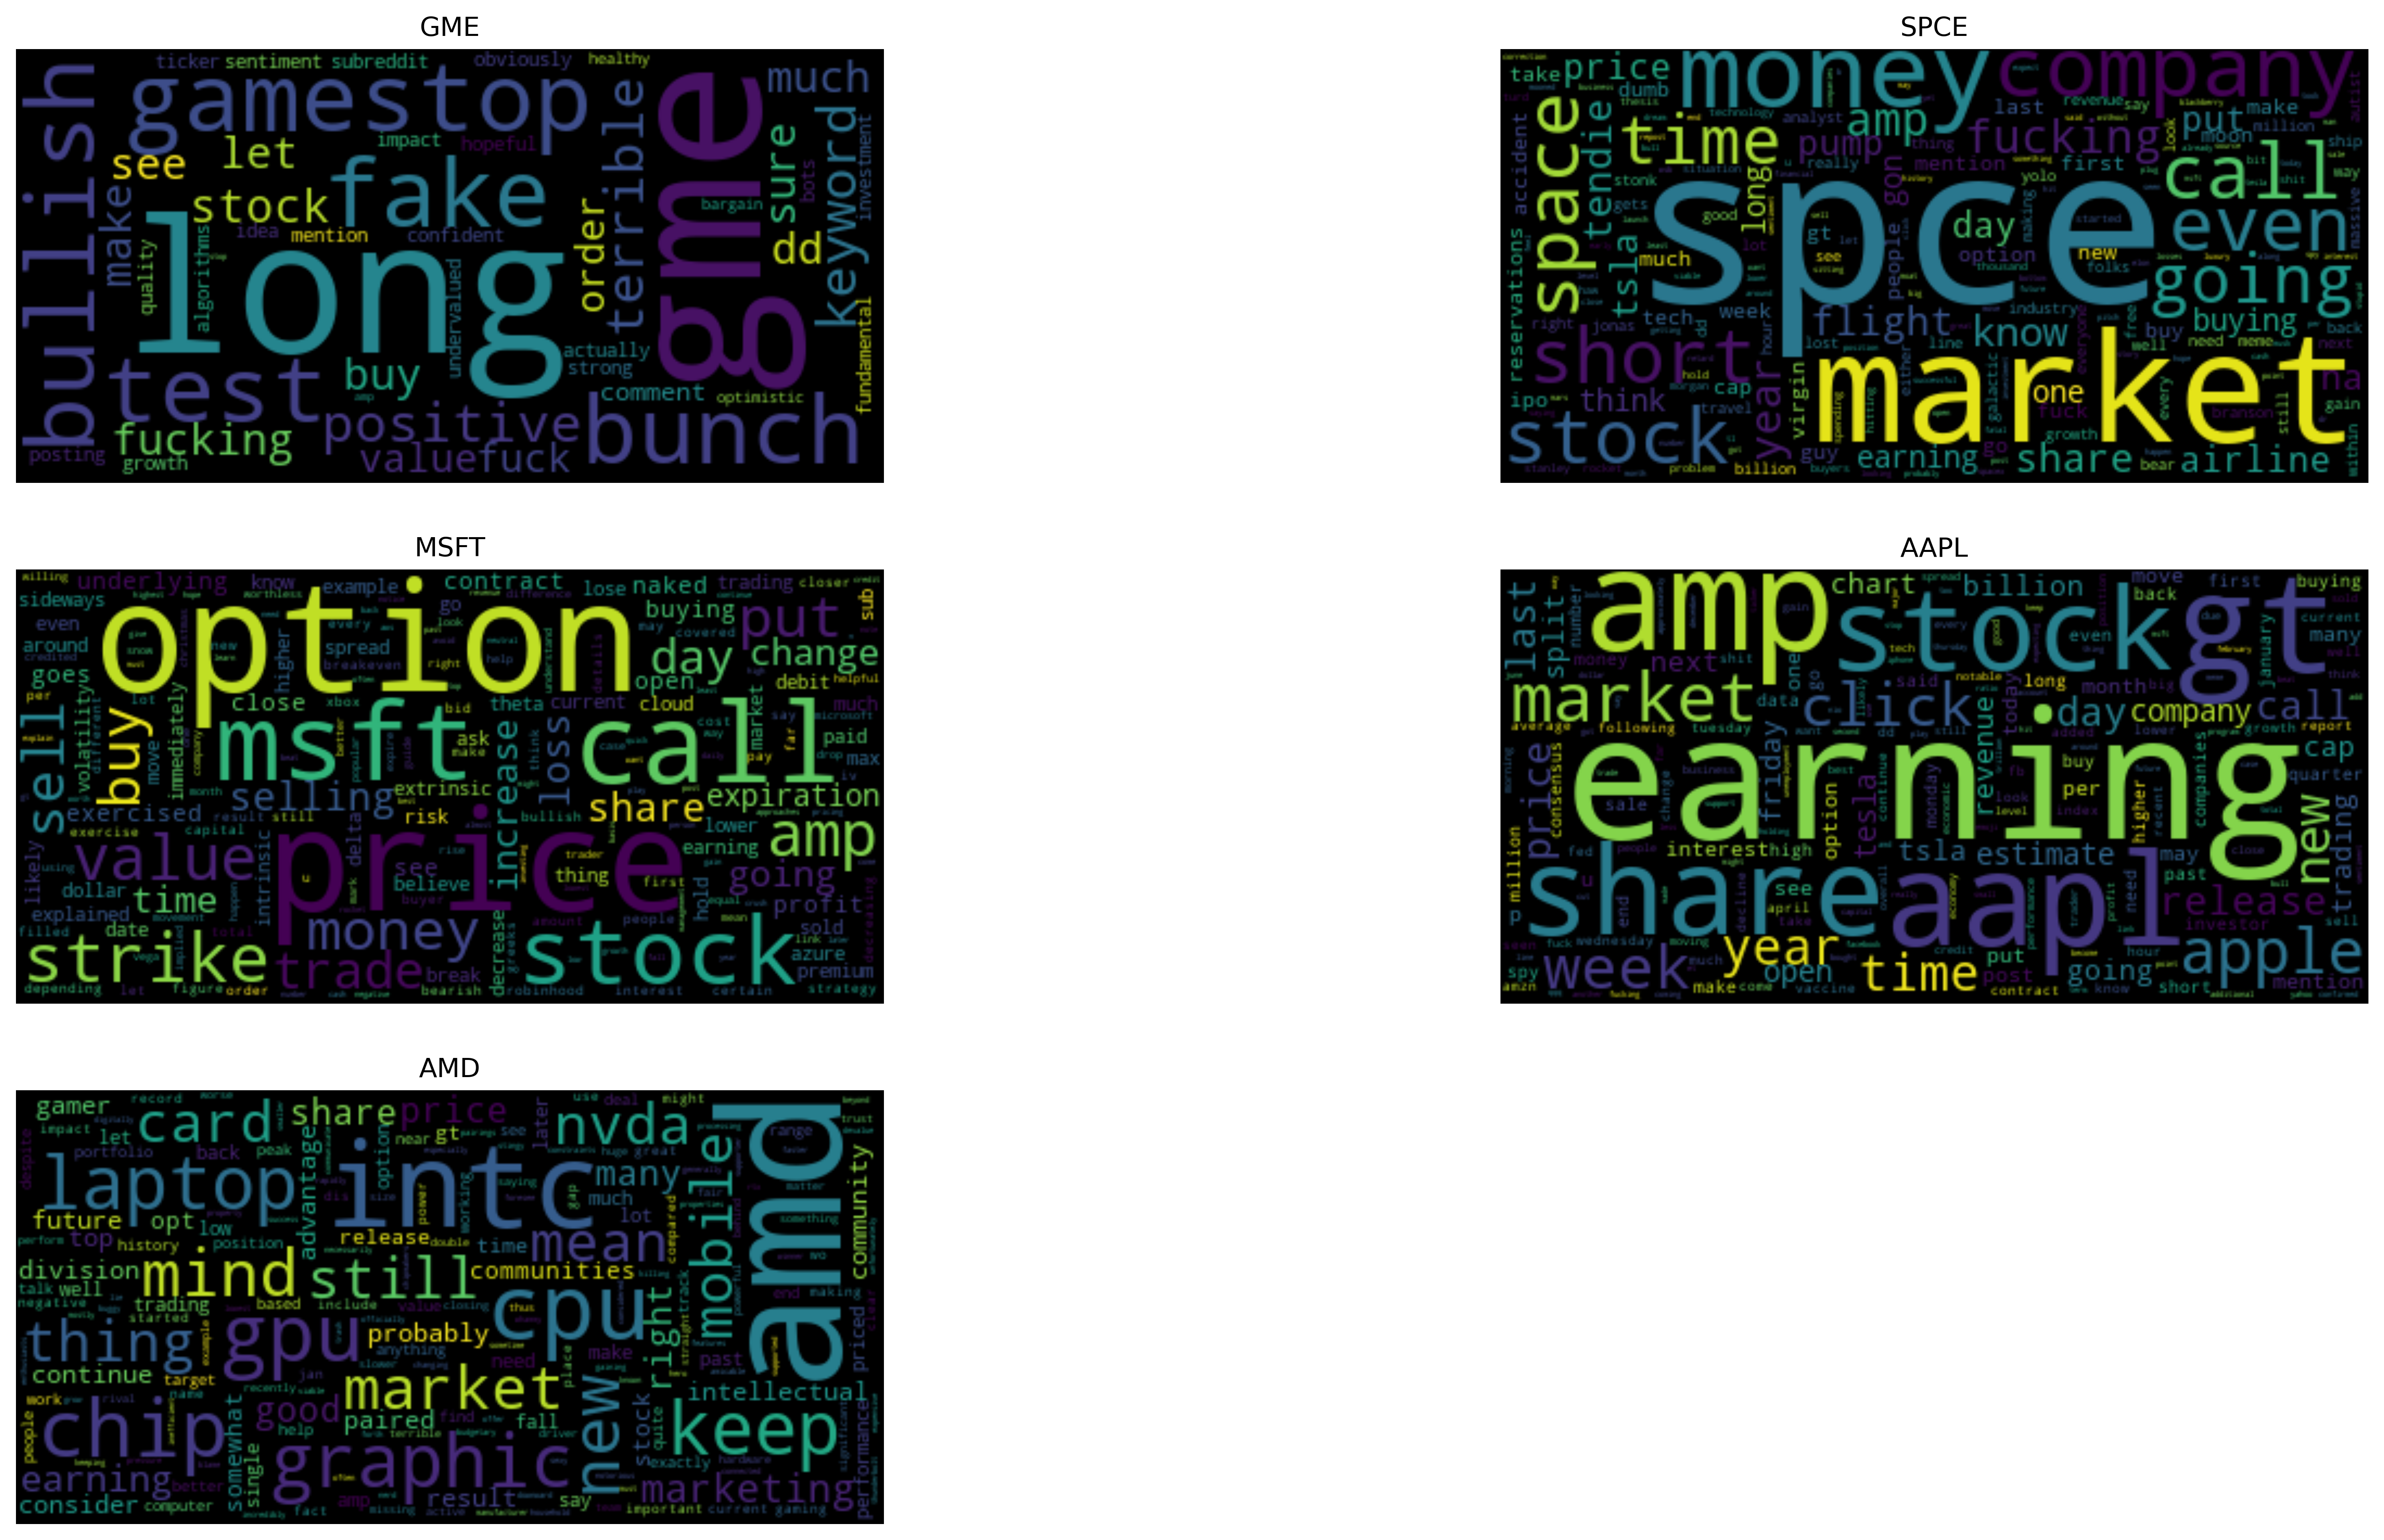

In [223]:
fig, axs = plt.subplots(3, 2, figsize=(22,12), dpi=400)
fig.delaxes(axs[2,1]) #The indexing is zero-based here
pic_number = 0
for i in range(3):
    for k in range(2):
        if (i,k) == (2,1):
            break
        axs[i,k].imshow(wordcloud[pic_number], interpolation='bilinear')
        axs[i,k].axis("off")
        axs[i,k].set_title((chosen_stocks[pic_number].upper()))
        pic_number += 1
#plt.savefig()

#### Comments: 
The shown word clouds definitely show expected words. However, as the clouds display more than just the 10 most frequent words, there are some new words in there. 

## Part 2: Sentiment analysis

We recreate the data foundation from the week 7 exercises. 

In [3]:
# Downloading the r/wallstreetbets submissions from the GitHub account
url = "https://raw.githubusercontent.com/JaQtae/SocInfo2022/main/wallstreet_subs.csv"
download = requests.get(url).content

wsb = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [6]:
# Creating the text of each submission
wsb["text"] = wsb["title"] + " " + wsb["selftext"]
# Tokenizing the text of each submission
wsb["tokens"] = wsb.apply(lambda x: clean_tokens(x["text"]), axis=1)

In [7]:
# Converting the UTC dates to Timestamps to resample the submissions for each day. 
wsb["timestamp"] = wsb.apply(lambda row : pd.Timestamp.utcfromtimestamp(row["created_utc"]), axis=1)
# Keep only date part of the timestamp
wsb["timestamp"] = wsb["timestamp"].dt.date

In [8]:
# Group the tokens by day
wsb_daily = wsb.groupby("timestamp").tokens.sum()

#### 2.1 Pick a day of your choice in 2020. We call it $d$. It is more interesting if you pick a day where you expect something relevant to occur (e.g. Christmas, New Year, Corona starting, the market crashes...).

We have picked May 31, 2020 on which there were protests against police brutality in response to the death of George Floyd. 

In [9]:
d = wsb_daily.index[152]
# Get 7 days before the day of interest
d_min = d - datetime.timedelta(days=7)

#### 2.2 Build two lists $l$ and $l_{ref}$ containing all tokens for submissions posted on r/wallstreebets on day $d$, and in the 7 days preceding day $d$, respectively. 

In [10]:
# List of tokens on day d
l = wsb_daily.loc[d]
# List of tokens of previous 7 days
l_ref = np.concatenate(wsb_daily[(wsb_daily.index<d) & (wsb_daily.index>d_min)].values)

#### 2.3 For each token $i$, compute the relative frequency in the two lists $l$ and $l_{ref}$. We call them $p(i,l)$ and $p(i,l_{ref})$, respectively. The relative frequency is computed as the number of times a token occurs over the total length of the document. Store the result in a dictionary.

In [11]:
# Dictionary with relative frequencies for all words in l
p = dict([(item[0], item[1]/len(l)) for item in Counter(l).items()])
# Dictionary with relative frequencies for all words in l_ref
p_ref = dict([(item[0], item[1]/len(l_ref)) for item in Counter(l_ref).items()])

#### 2.4 For each token $i$, compute the difference in relative frequency $\delta p(i) = p(i,l) - p(i,l_{ref})$. Store the values in a dictionary. Print the top 10 tokens (those with largest relative frequency). Do you notice anything interesting?

In [12]:
# All tokens in p and p_ref
all_tokens = set(p.keys()).union(set(p_ref.keys()))

In [13]:
# Dictionary to contain the differences in the relative frequencies between date d and the the previous days. 
# I use the .get method to handle the case where words are not included in either of the p or the p_ref dicts.
dp = dict([(token, p.get(token, 0) - p_ref.get(token, 0)) for token in all_tokens])

In [14]:
# Printing the top 10 tokens with the largest difference in relative frequency. 
sorted(dp.items(), key = lambda x:x[1], reverse=True)[:10]

[('riots', 0.004185885782638151),
 ('monday', 0.0022834955852547192),
 ('also', 0.0022539155827383164),
 ('protests', 0.0021982252699438085),
 ('companies', 0.0019906220176856173),
 ('post', 0.0017047053582912852),
 ('thor', 0.0015289426656138428),
 ('uber', 0.0014287071120629984),
 ('economic', 0.001423835523970842),
 ('nly', 0.0013986013986013986)]

__Comments:__ <br>
These words (riots, protests) obviously taps in to the events of May 31, 2020. 
Also there are som unexpected words like "thor" and "uber". 

#### 2.5 Now, for each token, compute the happiness $h(i) = labMT(i) - 5$, using the labMT dictionary. Here, we subtract $5$, so that positive tokens will have a positive value and negative tokens will have a negative value. Then, compute the product $\delta \Phi = h(i)\cdot \delta p(i)$. Store the results in a dictionary. 


In [17]:
# Downloading the labMT data from the GitHub account
url = "https://raw.githubusercontent.com/JaQtae/SocInfo2022/main/Hedonometer.csv"
download = requests.get(url).content

labMT = pd.read_csv(io.StringIO(download.decode('utf-8')))

# Recreating the dictionary containing the happiness score for all words in the labMT dataset.
h_score_dict = dict(zip(labMT["Word"], labMT["Happiness Score"]))

In [19]:
# Computing the happiness score for each token. 
h = dict([(token, h_score_dict.get(token, np.nan)-5) for token in all_tokens])
# Computing the product
dPhi = [(token, h[token]*dp[token]) for token in all_tokens if not np.isnan(h[token])]

#### 2.6 Print the top 10 tokens, ordered by the absolute value of $|\delta \Phi|$. Explain in your own words the meaning of $\delta \Phi$. If that is unclear, have a look at [this page](https://shifterator.readthedocs.io/en/latest/cookbook/weighted_avg_shifts.html).


In [20]:
sorted(dPhi, key = lambda x:np.abs(x[1]), reverse=True)[:10]

[('earnings', -0.007147162264888921),
 ('gold', -0.0035603668621259953),
 ('billion', 0.0035229530655782344),
 ('covid', -0.003409796237942381),
 ('pandemic', -0.003153599770649838),
 ('today', -0.0029043251641357186),
 ('cash', -0.002813558015181831),
 ('negative', -0.002703264559827483),
 ('crisis', -0.002577249543420044),
 ('losses', -0.0025150484758062566)]

__Explanation:__ <br>
$\delta \Phi$ basically indicates how much a word changes the overall happiness of a document, because we weight a word's happiness score with the change in its frequency of use. The above ten words are thus the words that change the happines on May 31, 2020 the most.

#### 2.7 Use the function ``shifterator.WeightedAvgShift`` to plot the WordShift, showing which words contributed the most to make your day of choice _d_ happier or more sad then days in the preceding 7 days. Comment on the figure.

C:\Users\Lasse\anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


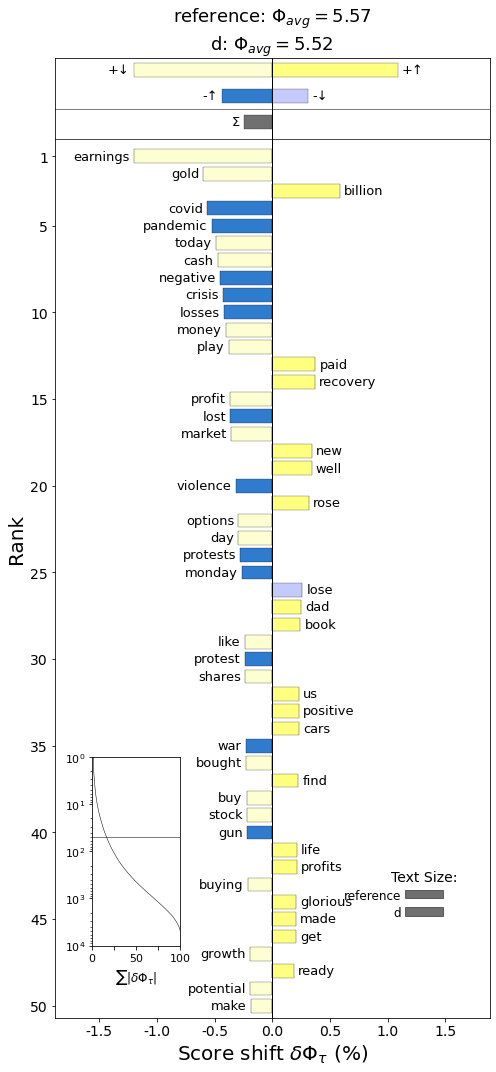

<AxesSubplot:title={'center':'reference: $\\Phi_{avg}=$5.57\nd: $\\Phi_{avg}=$5.52'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [22]:
sentiment_shift = sh.WeightedAvgShift(type2freq_1=p_ref,
                                     type2freq_2=p,
                                     type2score_1=h_score_dict,
                                     reference_value=5)
sentiment_shift.get_shift_graph(detailed=True,
                               system_names = ["reference", "d"])

__Comments:__<br>
We see that the net happiness score of the submissions on May 31, 2020 is lower than the preceding week. This is, to a large extent, caused by a decrease in the use of the positive words "earnings" and "gold". This date, however, also saw an increase in the use of the positive word "billion" which made a positive contribution to the overall happiness of the date.
Given the events that unfolded on this date, we find it surprising that the daily sentiment seems to be impacted the most by words relating to the stock market and the pandemic and not so much by words directly relating to the social unrest caused by the murdering of George Floyd. However, we need to take into account that the subreddit is fundamentally about the stock market, so it is unlikely to not have words related to this topic impact the happiness score.  

#### 2.8 How do words that you printed in step 6 relate to those shown by the WordShift? 

It's the same words! Here we just visualize the effect of $\delta \Phi$ for each word. 

## Part 3: Communities for the Zachary Karate Club Network

_Exercise: Zachary's karate club_: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable/auto_examples/graph/plot_karate_club.html).

In [41]:
G = nx.karate_club_graph()

#### 3. 1 Visualize the graph using [netwulf](https://netwulf.readthedocs.io/en/latest/). Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.

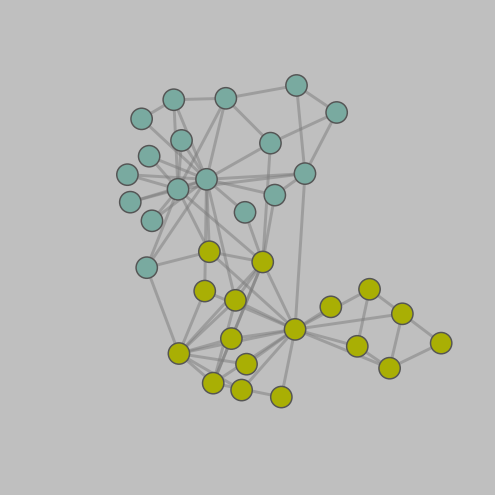

In [4]:
with plt.style.context('classic'):
    network, config = visualize(nw.get_filtered_network(G, node_group_key='club'), plot_in_cell_below=False)
    fig, ax = nw.draw_netwulf(network) 

#### 3.2 Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

In [42]:
def modularity(N: Graph, partitioning: list):
    L = len(N.edges()) # Number of links
    M = 0 # Modularity
    for p in partitioning:
        subgraph = N.subgraph(p).copy()
        L_c = subgraph.number_of_edges() #Community links
        K_c = sum(G.degree[node] for node in subgraph.nodes()) #degree of nodes in C
        M += (L_c/L) - (K_c/(2*L))**2 #(9.12)
    return M

#### 3.3 Explain in your own words the concept of _modularity_. 

__Answer:__ <br>
The modularity measures the degree to which a network deviates from the expected number of edges between between nodes if the all wirings had been randomly constructed.

#### 3.4 Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.

In [43]:
# Creating the two partitions
mrhi = {key for (key, value) in dict(nx.get_node_attributes(G, "club")).items() if value == 'Mr. Hi'}
officer = {key for (key, value) in dict(nx.get_node_attributes(G, "club")).items() if value == 'Officer'}

In [44]:
print('Modularity of the Karate club split partitioning : ' + str(round(modularity(G, [mrhi, officer]),5)))

Modularity of the Karate club split partitioning : 0.35823


#### 3.5  We will now perform a small randomization experiment to assess if the modularity you just computed is statistically different from $0$. To do so, we will implement a [configuration model](https://en.wikipedia.org/wiki/Configuration_model). In short, we will create a new network, such that each node has the same degree as in the original network, but different connections. 

__Answer:__
To do so, we will implement the double edge swap algorithm. Here is how the algorithm works: <br>
    - a. Create an identical copy of your original network. <br>
    - b. Consider two edges in your new network (u,v) and (x,y), such that u!=v and v!=x. <br>
    - c. If none of edges (u,y) and (x,v) exists already, add them to the network and remove edges (u,v) and (x,y). <br>
    - d. Repeat steps b. and c. to achieve at least N swaps.


In [45]:
# Double edge swap algorithm
def DES(G: Graph, N: int) -> Graph:
    G_random = G.copy() # create and identical copy of the original network
    num_swaps = 0
    while num_swaps <= N:
        edges = list(G_random.edges)
        non_edges = list(nx.non_edges(G_random))
        # Consider two edges in the new network
        (u, v) = random.choice(edges)
        (x, y) = random.choice(edges)
        if u==x or v==y: 
            continue 
        # If non of edges (u, y) annd (x, v) exists already, add them to the network and remove edges (u, v) and (x, y)
        if (u, x) in non_edges and (v, y) in non_edges:
            G_random.add_edges_from([(u,x), (v, y)])
            G_random.remove_edges_from([(u, v), (x, y)])
            num_swaps += 1
    return G_random

G_new = DES(G, G.number_of_edges()) 

#### 3.6 Is the degree of the nodes in your original and the configuration model network the same? Why?

In [46]:
# We check if the degree for each node is the same in the two networks.
len(G.degree) == sum([G.degree[i] == G_new.degree[i] for i in range(len(G.degree))])

True

__Answer:__
We find that the degree of the nodes in our original network matches the degrees in the configuration model network. This is simply the output of the double edge swap algorithm. This is because the algorithm just swaps the wiring for two pairs of connected nodes, therefore all four nodes still retain an outgoing link, only to a different node.

####  3.7 Create $1000$ randomized version of the Karate Club network using the algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.

In [53]:
random_kcnets = []
n = 1000
for _ in tqdm(range(n)):
    G_new = DES(G, G.number_of_edges())
    random_kcnets.append(modularity(G_new, [mrhi, officer]))

100%|██████████| 1000/1000 [02:23<00:00,  6.99it/s]


#### 3.8 Compute the average and standard deviation of the modularity for the configuration model.

In [62]:
print('Avg. Modularity: {} \nStandard deviation: {}'.format(round(np.mean(random_kcnets),6), round(np.std(random_kcnets),6)))

Avg. Modularity: 0.002081 
Standard deviation: 0.046748


__Comment:__<br>
After the random rewiring, the mean modularity is centered around 0. This means that the connectivity between the nodes in the partitions can be interpreted as being random, fully explained by the degree distribution. Therefore they don't represent potential communities. This is also expected from a randomly wired network, as described in the theory.

#### 3.9 Plot the distribution of the configuration model modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)).

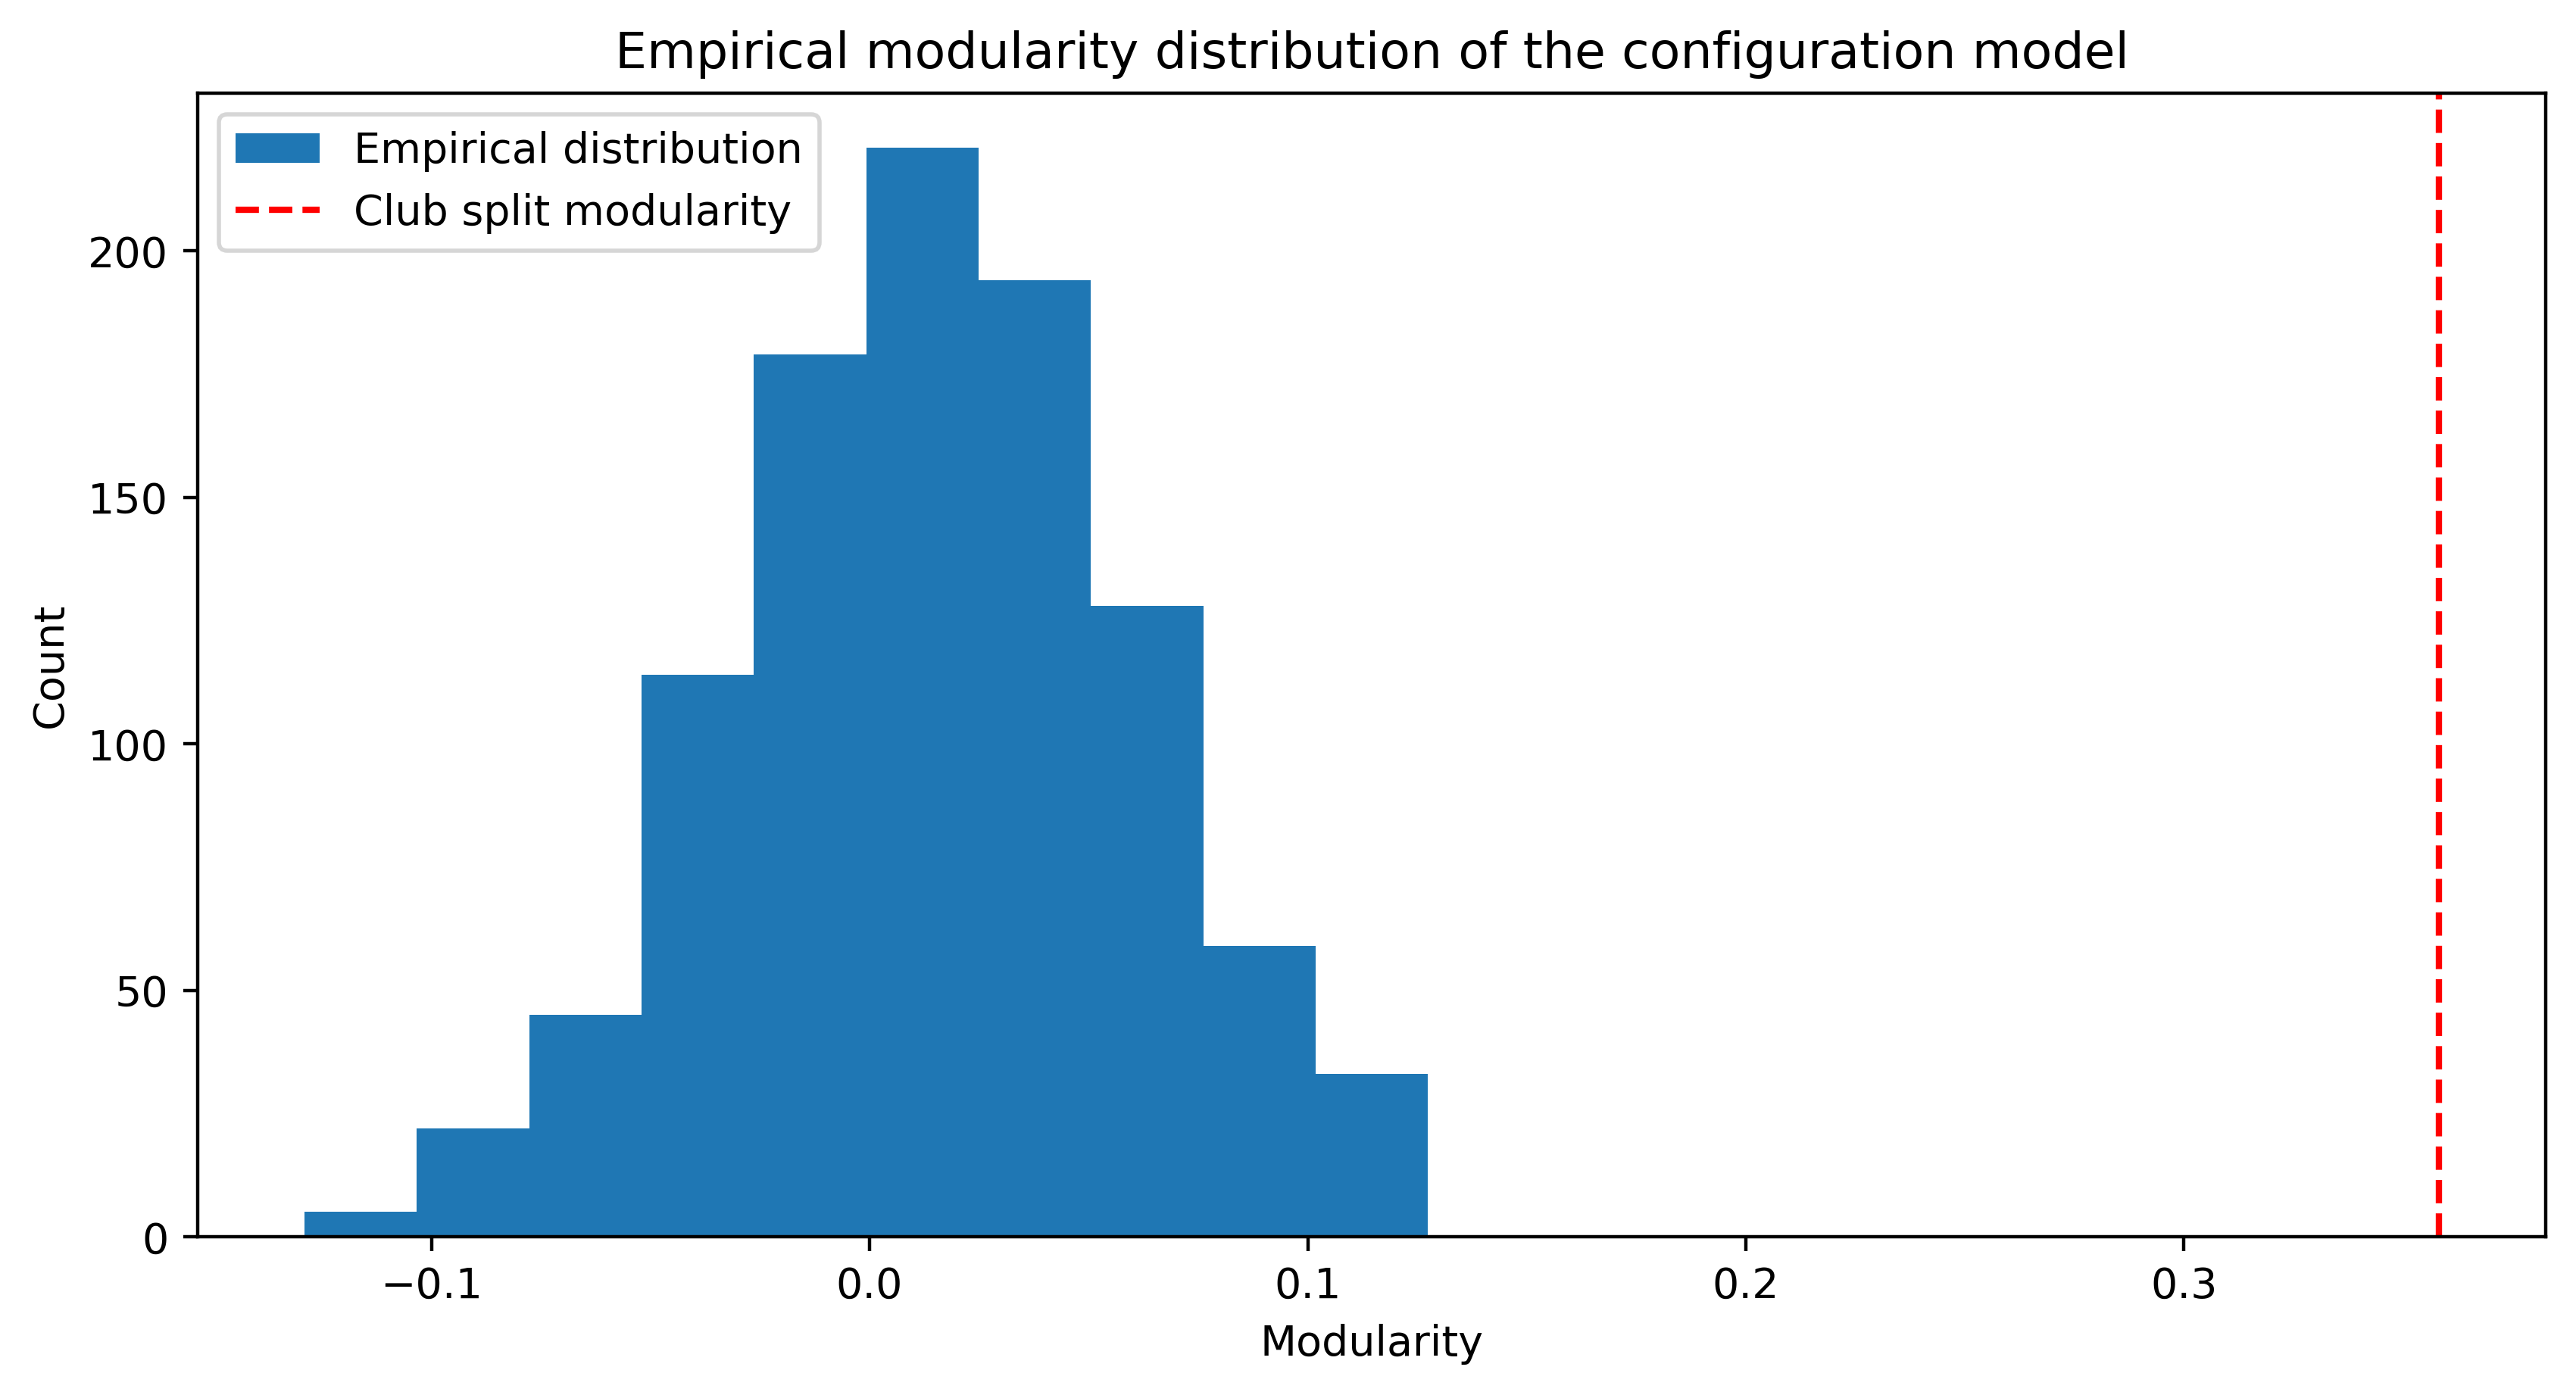

In [60]:
fig, ax = plt.subplots(figsize=(10,5), dpi=400)
ax.hist(random_kcnets, label="Empirical distribution", bins=10)
ax.axvline(modularity(G, [mrhi, officer]), linestyle='--', color='r', label="Club split modularity")
ax.set_title("Empirical modularity distribution of the configuration model")
ax.set_ylabel("Count")
ax.set_xlabel("Modularity")
ax.legend()

#### 3.10 Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to compare with the configuration model? What is the reason why we preserved the nodes degree?

__Answer:__<br>
Looking at the plot, not even one of the 1000 configuration model networks had a modularity higher than the modularity observed in the club split. This indicates that there are fewer edges between the communities of `mrhi` and `officer` than we would expect using a randomly connected graph. So, it is fair to say the club split is a good partitioning. The node degree preservation is due to the addition of an edge whenever one is removed, ie. a swap of edges, which guarantees equivalency between the sizes of the network. This degree preservation is ultimately what legitimizes this experiment serving to indicate that the modularity of the club partitioning is statistically different from 0. 

#### 3.11  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

In [94]:
partition = community_louvain.best_partition(G, random_state=seed)
partition_dict = {item: set() for (key, item) in partition.items()}
# For Louvain vs Our own
for (key, item) in partition.items():
    partition_dict[item].add(key)
modularity(G, list(partition_dict.values())), modularity(G, [mrhi, officer])

(0.4151051939513477, 0.3582347140039447)

In [95]:
len(partition_dict)

4

__Answer:__<br>
The above results show that the best partitioning found by the Louvain-algorithm consists of four communities, rather than the original two, which yields a higher modularity than what was observed for the club split. This comparison reveals that the split yielding the optimal modularity, given the network architecture, can't be obtained with two communities only, but rather four. 

#### 3.12  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [96]:
A = len(partition_dict.keys())
D = np.zeros((2, A))
for i in range(D.shape[0]):
    for j in range(D.shape[1]):
        D[i, j] = sum([1 for x in partition_dict[j] if x in [mrhi, officer][i]])
D

array([[11.,  0.,  5.,  1.],
       [ 0.,  4.,  0., 13.]])

__Answer:__ <br>
The four communities detected by the Louvain algorithm seems to simply be a split of the two original communities, such that nearly none (only one) of the original community members of different clubs are in the same Louvain community. This would correspond to having sub-communities within each of the clubs. 

#### 3.13  Consider the GME network you built in [Week 4](https://github.com/lalessan/comsocsci2022/blob/main/lectures/Week4.ipynb), part 2.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0?  


In [ ]:
#Louvain requires undirected graph
#Taget kode fra Week 4, gemt den til gexf format
G_GME = nx.read_gexf("G_U_reddit.gexf")
communities = community_louvain.best_partition(G_GME)
nx.set_node_attributes(G_GME, communities, "louvain_community")
print(f'The amount of communities: {max(list(communities.values())) + 1}')


> * Visualize the network, using netwulf (see Week 4). This time assign each node a different color based on their _community_. Describe the structure you observe.